## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://hf.co/datasets/emotion)

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Importing libraries
2. Defining a show_history function() to plot training trend

In [2]:
%matplotlib inline

import tensorflow as tf
import datasets
import numpy as np
import matplotlib.pyplot as plt
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = datasets.load_dataset('emotion')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, label = get_tweets(train)

In [8]:
tweets[0], label[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
print(tweets[0])
tokenizer.texts_to_sequences([tweets[0]])

i didnt feel humiliated


[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

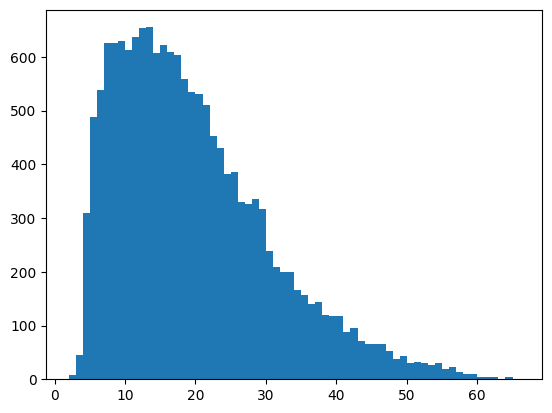

In [12]:
lengths = [len(t.split(" ")) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [15]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [16]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
classes = set(label)
classes

{0, 1, 2, 3, 4, 5}

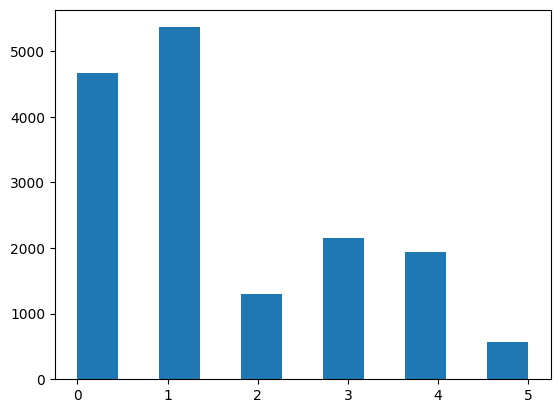

In [18]:
plt.hist(label, bins=11)
plt.show()

In [19]:
labels = dataset['train'].features['label'].int2str
num_labels = dataset['train'].features['label'].num_classes
str_labels = [labels(i) for i in range(num_labels)]

In [21]:
label_to_index = dict((c,i) for i, c in enumerate(str_labels))
index_to_label = dict((v,k) for k,v in label_to_index.items())

In [22]:
index_to_label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [23]:
label_to_index

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [24]:
id2label_map = lambda label_ids: [index_to_label[label_id] for label_id in label_ids]
train_labels = id2label_map(label)
train_labels[:5]

['sadness', 'sadness', 'anger', 'love', 'anger']

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [25]:
import numpy as np
from keras import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

In [41]:
vocab_size = tokenizer.num_words

In [42]:
model = Sequential([
    Embedding(vocab_size, 16),
    Bidirectional(LSTM(20, return_sequences=True)),
    Bidirectional(LSTM(20)),
    Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [43]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_str_labels = id2label_map(val_labels)

In [44]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [45]:
padded_train_sequences = np.array(padded_train_sequences)
label = np.array(label)
val_sequences = np.array(val_sequences)
val_labels = np.array(val_labels)

In [46]:
_ = model.fit(
    padded_train_sequences, label,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ],
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - accuracy: 0.3807 - loss: 1.5430 - val_accuracy: 0.6240 - val_loss: 1.0139
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.6875 - loss: 0.8640 - val_accuracy: 0.7310 - val_loss: 0.7720
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.7831 - loss: 0.6178 - val_accuracy: 0.7870 - val_loss: 0.6204
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.8607 - loss: 0.3902 - val_accuracy: 0.8415 - val_loss: 0.5513
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.9311 - loss: 0.2187 - val_accuracy: 0.8880 - val_loss: 0.3718
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 76ms/step - accuracy: 0.9549 - loss: 0.1463 - val_accuracy: 0.8940 - val_loss: 0.3736
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.9696 - loss: 0.0936 - val_accuracy: 0.8940 - val_loss: 0.3790
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - accuracy: 0.9789 - loss: 0.0684 - 

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

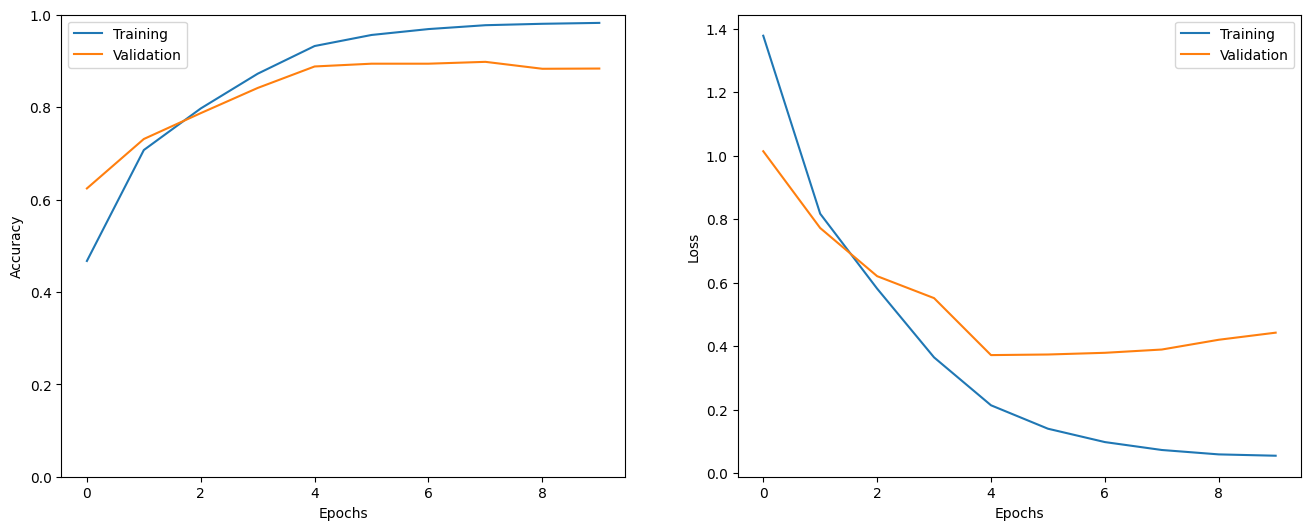

In [47]:
show_history(_)

In [48]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_str_labels = id2label_map(test_labels)

In [52]:
evaluate = model.evaluate(np.array(test_sequences), np.array(test_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8833 - loss: 0.4370


In [82]:
rand_index = random.randint(0, len(test_tweets) - 1)
user_tweet = test_tweets[rand_index]
print(f"Tweet: {user_tweet}")
print(f"Actaul Label: {test_str_labels[rand_index]}")

Tweet: i feel very mislead by someone that i really really thought i knew and liked very much so
Actaul Label: love


In [83]:
y_pred = model.predict(np.expand_dims(test_sequences[rand_index], axis=0))[0]
print(f"Predicted Label: {str_labels[np.argmax(y_pred)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: love


In [89]:
preds = model.predict(test_sequences)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


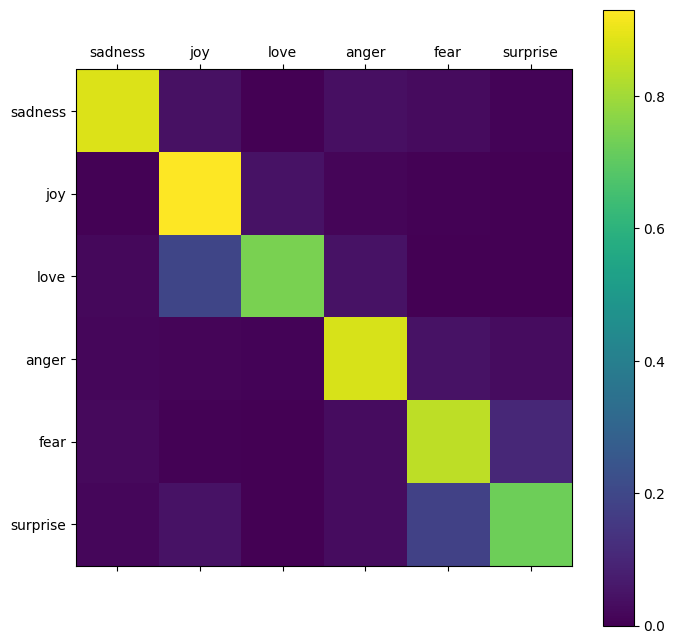

In [90]:
show_confusion_matrix(test_labels, np.argmax(preds, axis=1), str_labels)